# Imports

In [1]:
import numpy   as np
import pandas  as pd

from typing import List, Dict

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

In [2]:
from dstoolkit.automl import AutoMLHistGradientBoostingRegressor, AutoMLHistGradientBoostingRegressorCV

/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Regressor

In [3]:
df = pd.read_csv('../data/global_temperature_time_series.csv', )
df['time'] = pd.to_datetime(df['Year'])
df = df.drop(columns=['Source', 'Year']).rename(columns={'Mean': 'temperature'})

import warnings

import numpy  as np
import pandas as pd

from typing import List, Dict

from scipy.stats import skew, kurtosis


class SimpleLagTimeFeatureCreator:
    
    def __init__(self, windows: List[int] = [2, 3, 4], functions: List[str] = ["mean", "median", "max", "min"]):
        
        """
        Initiate the lag feature creator.
        
        Args:
            windows: List of window sizes for calculating statistics
            functions: List of functions to be applied (mean, median, max, min, etc.)

        Raises:
            UserWarning: If the list of windows contains the value 1
        """
        
        self.windows = windows
        self.functions = functions
        
        self._function_map = {
            'mean': np.mean,
            'median': np.median,
            'max': np.max,
            'min': np.min,
            'sum': np.sum,
            'std': lambda x: np.std(x, ddof=1),
            'diff': np.ptp,
            'kurt': lambda x: kurtosis(x, bias=False),
            'skew': lambda x: skew(x, bias=False),
            'slope': self._calc_slope
        }

        if 1 in self.windows:
            warnings.warn(
                "Window size 1 was found. Windows with size equal to 1 are not recommended for lag/rolling calculations, because they do not aggregate temporal information.",
                UserWarning
            )
            self.windows.remove(1)
    
    def _calc_slope(self, x: np.ndarray) -> float:
        
        """Calculates the slope using least squares."""
        
        return np.polyfit(np.arange(len(x)), x, 1)[0]

    def _create_lag_features(self, series: pd.Series) -> Dict[str, pd.Series]:
        
        """Creates all lagged features for a time series."""
        
        lag_one = series.shift(1)
        features = {f'{series.name}_sum_1_lag': lag_one}
        
        valid_funcs = [func for func in self.functions if func in self._function_map]
        
        for func in valid_funcs:
            
            func_operation = self._function_map[func]
            
            for win in self.windows:
                
                feature_values = lag_one.rolling(window=win, min_periods=2).apply(func_operation, raw=True)
                features[f'{series.name}_{func}_{win}_lag'] = feature_values
        
        return features
    
    def calculate(self, df: pd.DataFrame, target: str, time: str) -> pd.DataFrame:
        
        """
        Calculates all features with temporal lag for the target column.
        
        Args:
            df: Input DataFrame
            target: Name of the target column for feature calculation
            time: Name of the column with temporal data
            
        Returns:
            DataFrame with the new features added
        """
        
        if target not in df.columns:
            raise ValueError(f"Coluna '{target}' não encontrada no DataFrame")
            
        df = df.sort_values(by=time)
        
        features = self._create_lag_features(df[target])
        
        return df.assign(**features)

s = SimpleLagTimeFeatureCreator([2, 3, 4, 5, 6], ["mean", "median", "max", "min", "std", "diff", "slope"])
df1 = s.calculate(df, target='temperature', time='time')

X = df1.drop(columns=['time', 'temperature'])
y = df1[['temperature']]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.55, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, train_size=0.6, random_state=42)

best_features_reg = [
    'temperature_mean_4_lag',
    'temperature_mean_2_lag',
    'temperature_mean_6_lag',
    'temperature_max_2_lag',
    'temperature_sum_1_lag',
    'temperature_median_6_lag',
    'temperature_slope_3_lag',
    'temperature_min_6_lag',
    'temperature_min_4_lag',
    'temperature_max_6_lag',
    'temperature_slope_5_lag',
    'temperature_slope_2_lag',
    'temperature_slope_4_lag',
    'temperature_slope_6_lag',
    'temperature_std_6_lag',
    'temperature_std_2_lag',
    'temperature_median_3_lag',
    'temperature_min_3_lag']

In [4]:
a = AutoMLHistGradientBoostingRegressor(
    X_train, y_train, 
    X_valid, y_valid,
    X_test, y_test,
    target='temperature',
    best_features=best_features_reg,
    n_trials=50,
    scoring='r2'
)

In [5]:
a.train()

In [6]:
a.get_metrics()

,Dataset,R2,MAE,MadAE,MAPE,RMSE,Explained Variance,Model
0,Train,0.981484,0.042817,0.034388,6.908243e+11,0.055463,0.981484,Base Model
1,Valid,0.909999,0.091293,0.069904,8.566582e-01,0.120294,0.910352,Base Model
2,Test,0.896984,0.094639,0.070388,4.315804e+12,0.126842,0.897270,Base Model
3,Train,0.978171,0.046368,0.037685,8.615351e+11,0.060222,0.978171,Best Feature Model
4,Valid,0.910873,0.090336,0.067131,8.131116e-01,0.119709,0.911190,Best Feature Model
5,Test,0.898931,0.092616,0.069562,4.033583e+12,0.125637,0.899157,Best Feature Model
6,Train,0.948705,0.071249,0.057478,1.305419e+12,0.092315,0.948705,Best Params Model
7,Valid,0.917040,0.087653,0.066132,7.684986e-01,0.115493,0.917375,Best Params Model
8,Test,0.905068,0.090408,0.067033,4.022448e+12,0.121763,0.905390,Best Params Model


base_model Results


,Dataset,R2,MAE,MadAE,MAPE,RMSE,Explained Variance
0,Train,0.981484,0.042817,0.034388,6.908243e+11,0.055463,0.981484
1,Valid,0.909999,0.091293,0.069904,8.566582e-01,0.120294,0.910352
2,Test,0.896984,0.094639,0.070388,4.315804e+12,0.126842,0.897270


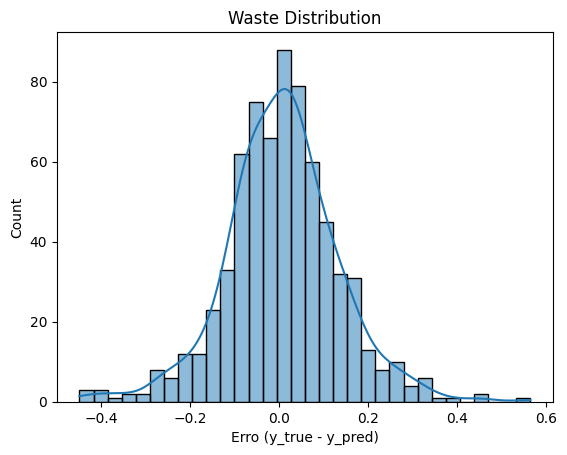

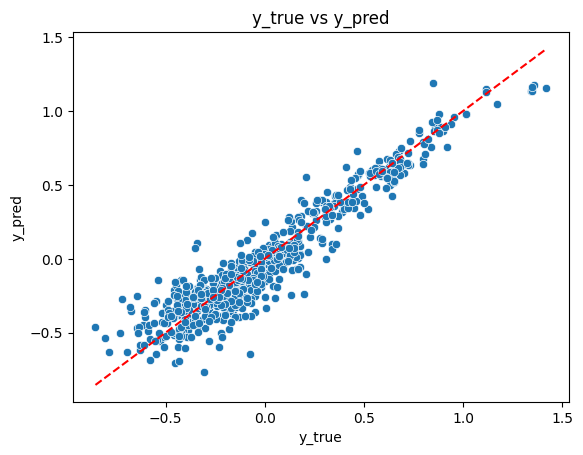

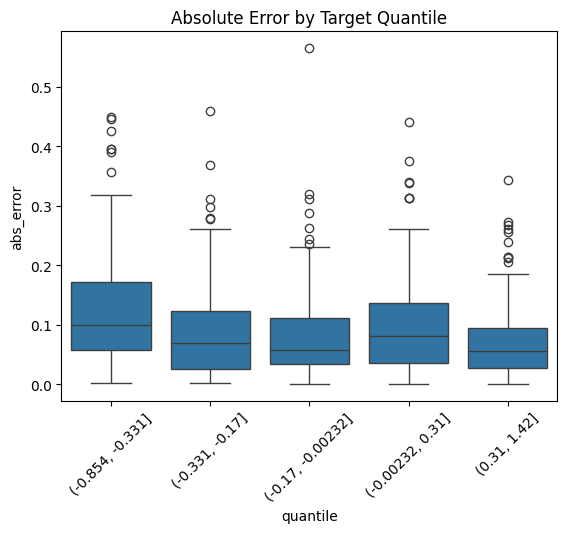

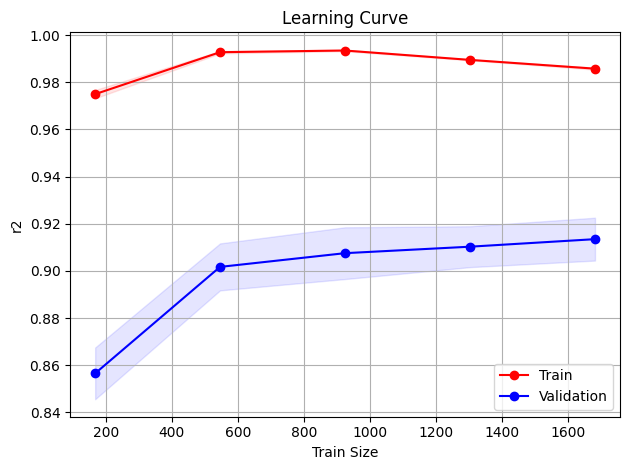

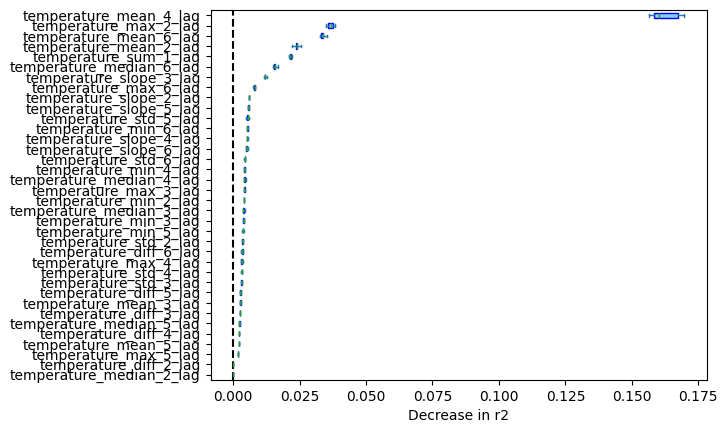

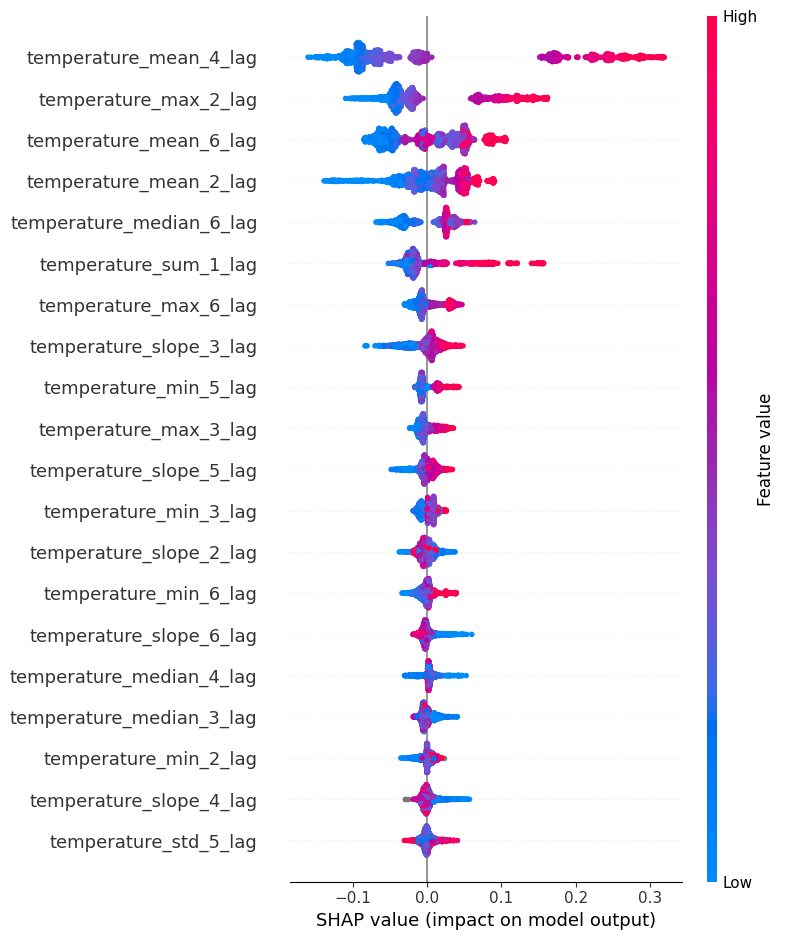

best_feature_model Results


,Dataset,R2,MAE,MadAE,MAPE,RMSE,Explained Variance
0,Train,0.978171,0.046368,0.037685,8.615351e+11,0.060222,0.978171
1,Valid,0.910873,0.090336,0.067131,8.131116e-01,0.119709,0.911190
2,Test,0.898931,0.092616,0.069562,4.033583e+12,0.125637,0.899157


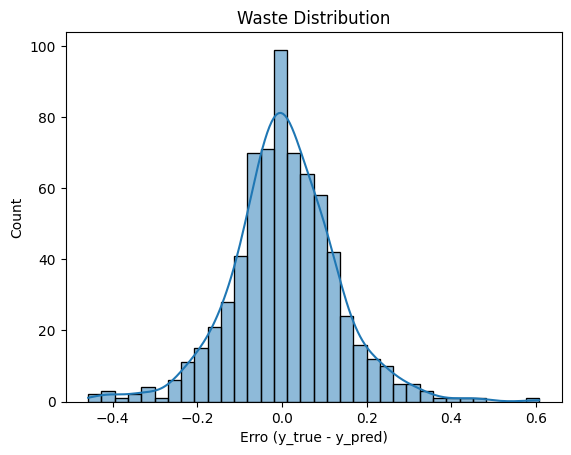

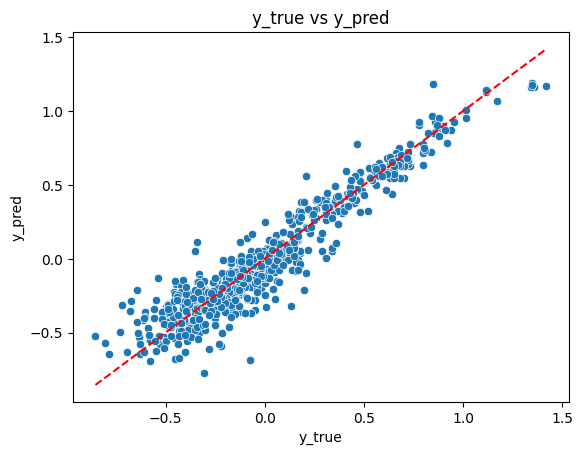

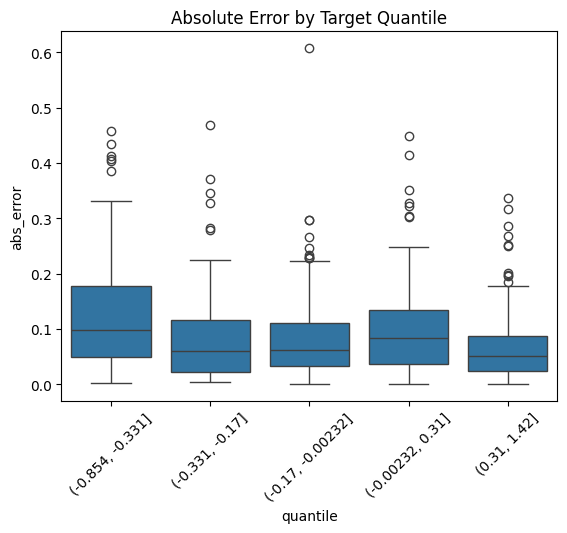

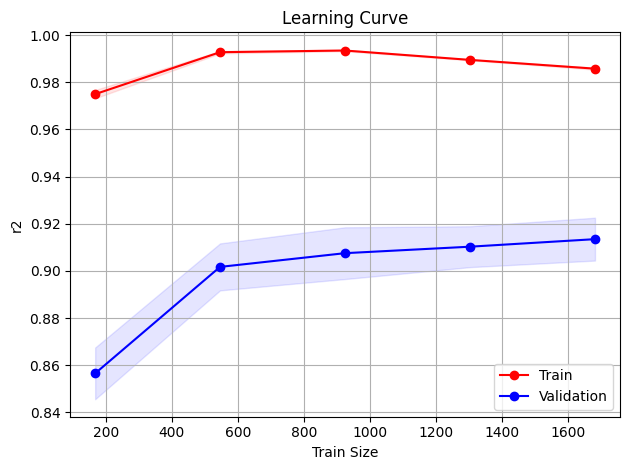

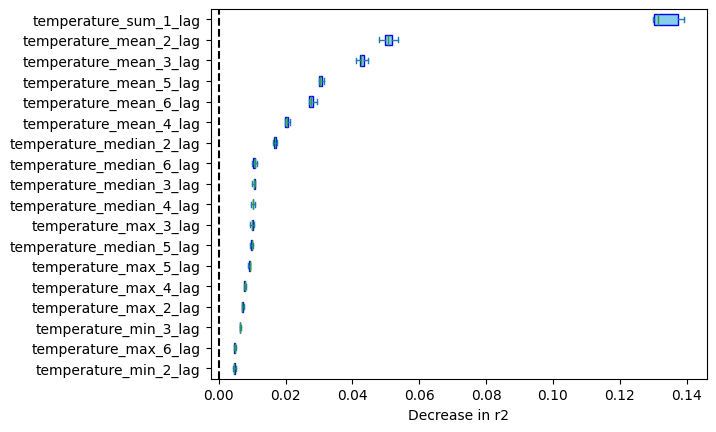

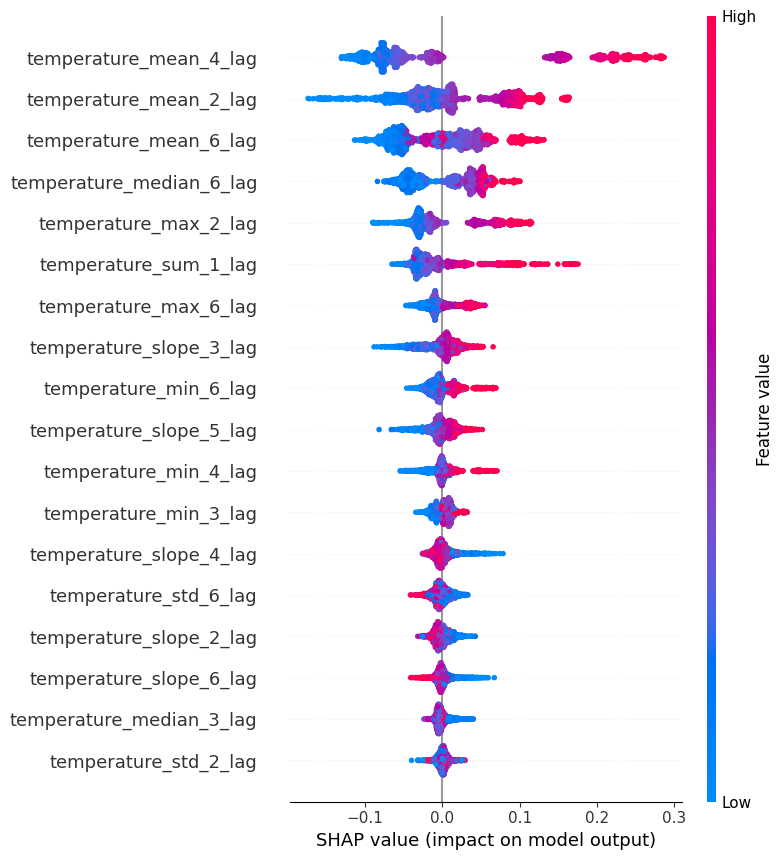

best_params_model Results


,Dataset,R2,MAE,MadAE,MAPE,RMSE,Explained Variance
0,Train,0.948705,0.071249,0.057478,1.305419e+12,0.092315,0.948705
1,Valid,0.917040,0.087653,0.066132,7.684986e-01,0.115493,0.917375
2,Test,0.905068,0.090408,0.067033,4.022448e+12,0.121763,0.905390


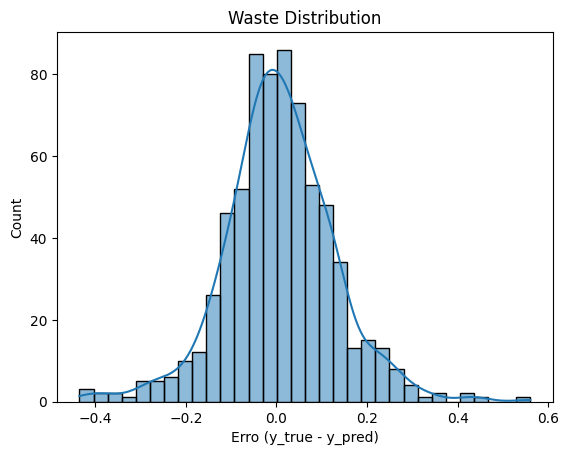

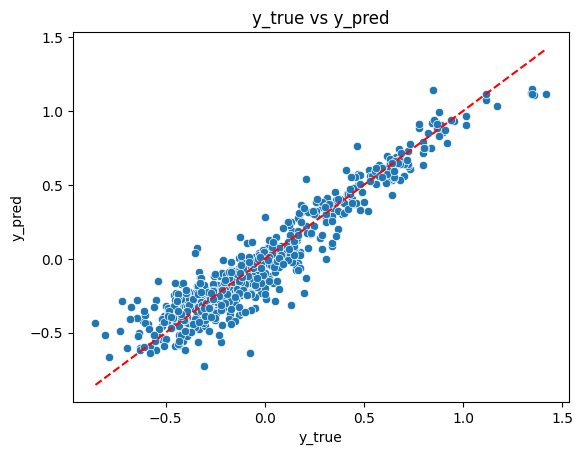

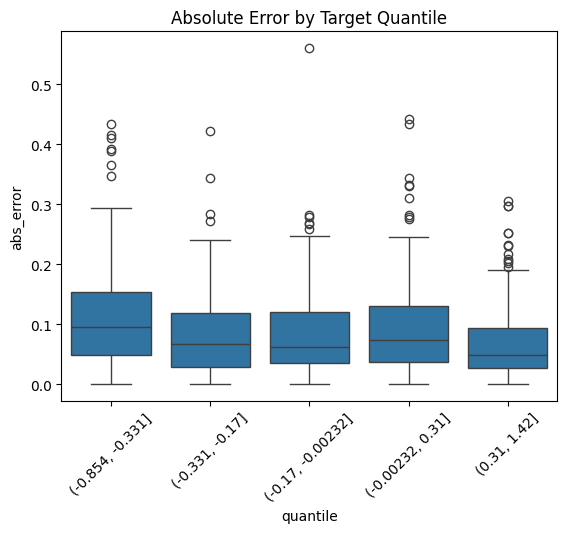

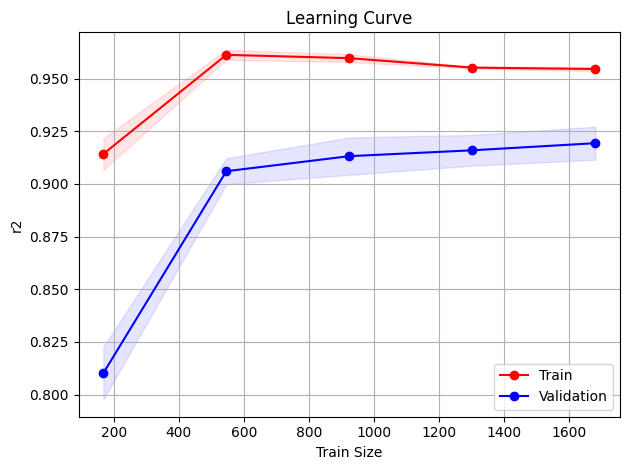

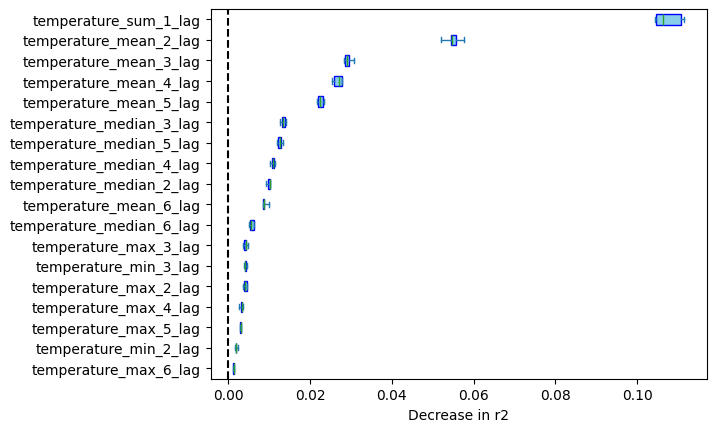

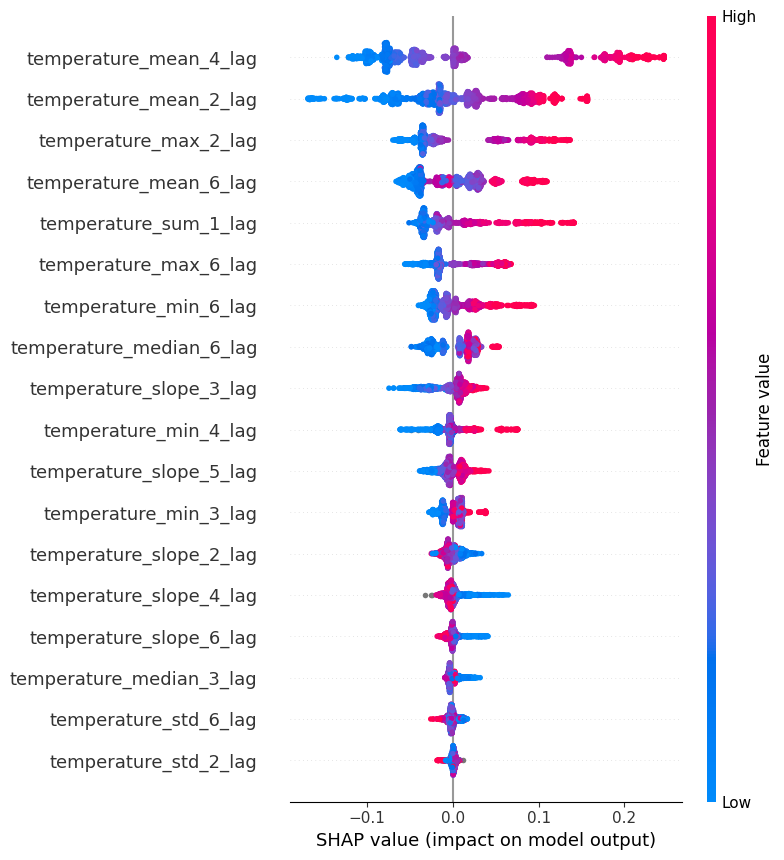

In [7]:
a.get_result_analysis()

# Classifier

In [3]:
from dstoolkit.automl import AutoMLHistGradientBoostingClassifier, AutoMLHistGradientBoostingClassifierCV

In [4]:
df = pd.read_csv('../data/cs-training.csv')

X = df.drop(['SeriousDlqin2yrs', 'Unnamed: 0'], axis=1)
y = df[['SeriousDlqin2yrs']].rename({'SeriousDlqin2yrs': 'target'}, axis=1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.6, random_state=42, stratify=y['target'])
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, train_size=0.6, random_state=42, stratify=y_temp['target'])

best_features_class = ['RevolvingUtilizationOfUnsecuredLines', 'NumberOfTimes90DaysLate', 'NumberOfTime30-59DaysPastDueNotWorse', 'age', 'DebtRatio', 'MonthlyIncome']

In [5]:
a = AutoMLHistGradientBoostingClassifier(
    X_train, y_train, 
    X_valid, y_valid, 
    X_test, y_test, 
    target='target', 
    best_features=best_features_class,
    n_trials=50,
    scoring='brier'
)

In [6]:
a.train()

In [7]:
a.get_metrics()

,Dataset,Treshold,Balanced Accuracy,Precision,Recall,F1,AUC,KS,Brier,Model
0,Train,0.211055,0.748034,0.434628,0.547041,0.484398,0.893041,0.626837,0.045960,Base Model
1,Valid,0.175879,0.745595,0.382918,0.555278,0.453265,0.867562,0.585563,0.048631,Base Model
2,Test,0.266332,0.699536,0.437616,0.439526,0.438569,0.859912,0.563715,0.049492,Base Model
3,Train,0.211055,0.720537,0.431517,0.487035,0.457598,0.881342,0.604027,0.047282,Best Feature Model
4,Valid,0.221106,0.705647,0.424477,0.455528,0.439455,0.858196,0.569636,0.049341,Best Feature Model
5,Test,0.175879,0.721122,0.354013,0.508728,0.417498,0.850497,0.539348,0.050343,Best Feature Model
6,Train,0.190955,0.718822,0.395215,0.491523,0.438139,0.864455,0.571230,0.048972,Best Params Model
7,Valid,0.211055,0.711953,0.423697,0.469659,0.445496,0.860320,0.567247,0.049157,Best Params Model
8,Test,0.190955,0.713431,0.380648,0.483167,0.425824,0.851575,0.542881,0.050077,Best Params Model


base_model Results


,Dataset,Treshold,Balanced Accuracy,Precision,Recall,F1,AUC,KS,Brier
0,Train,0.211055,0.748034,0.434628,0.547041,0.484398,0.893041,0.626837,0.045960
1,Valid,0.175879,0.745595,0.382918,0.555278,0.453265,0.867562,0.585563,0.048631
2,Test,0.266332,0.699536,0.437616,0.439526,0.438569,0.859912,0.563715,0.049492


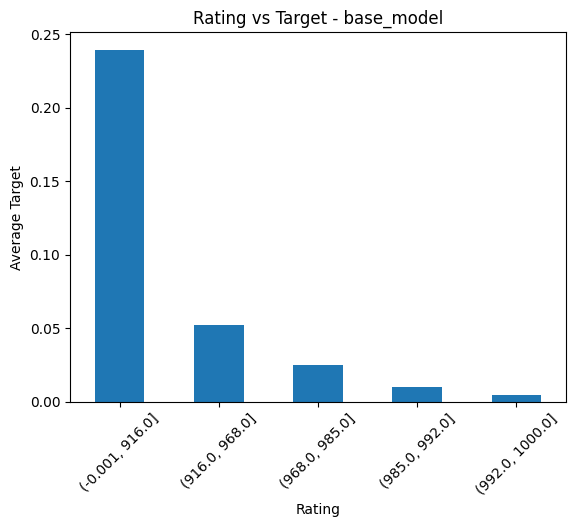

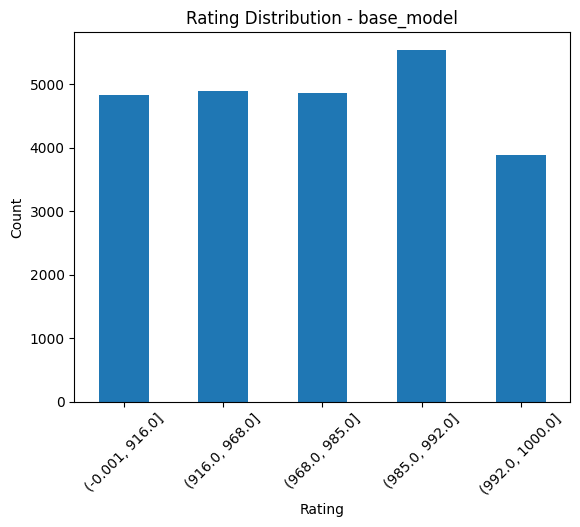

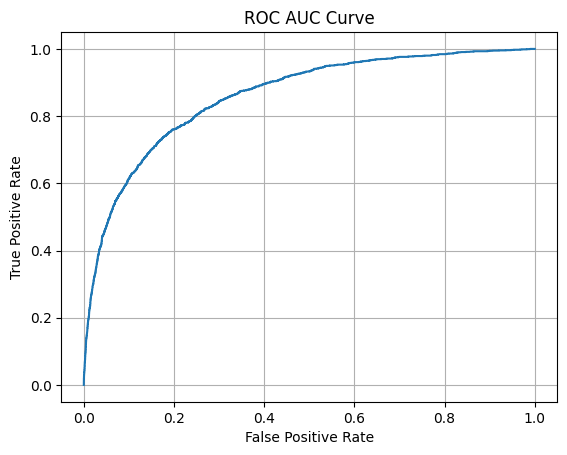

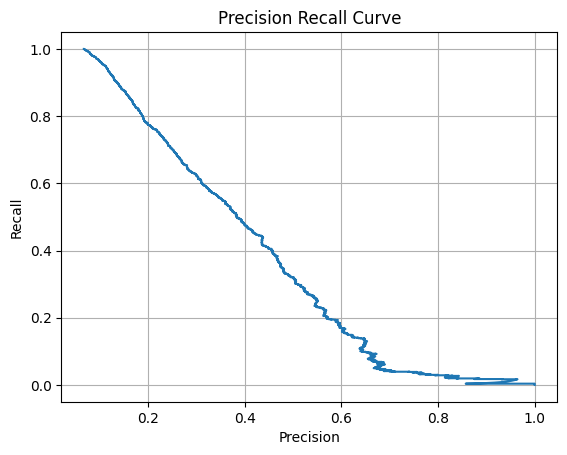

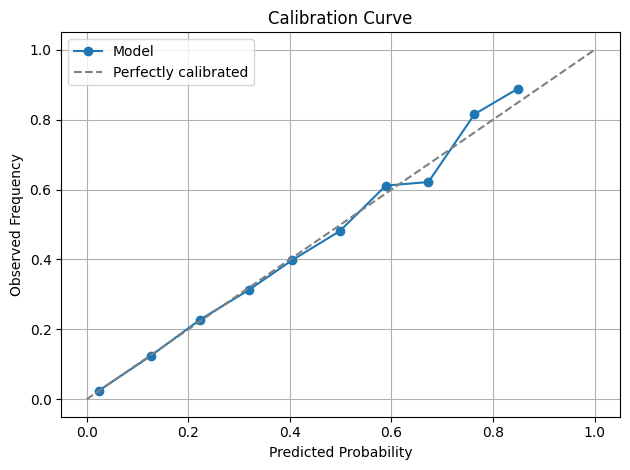

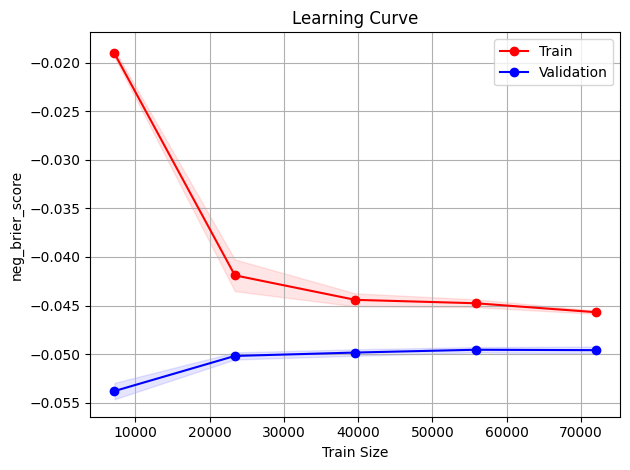

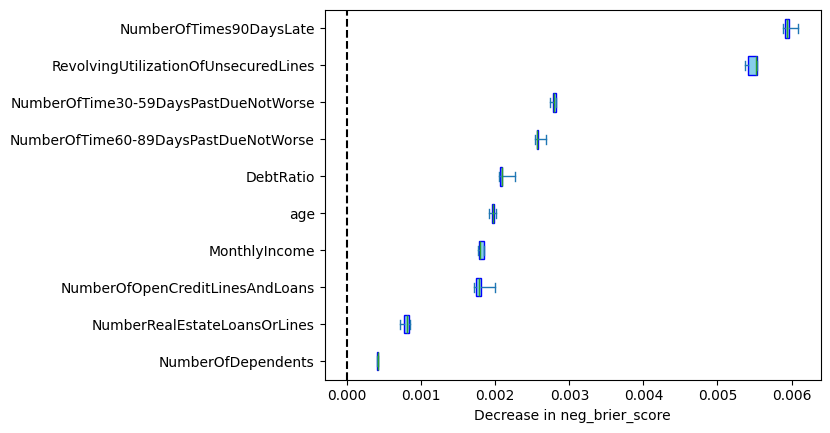

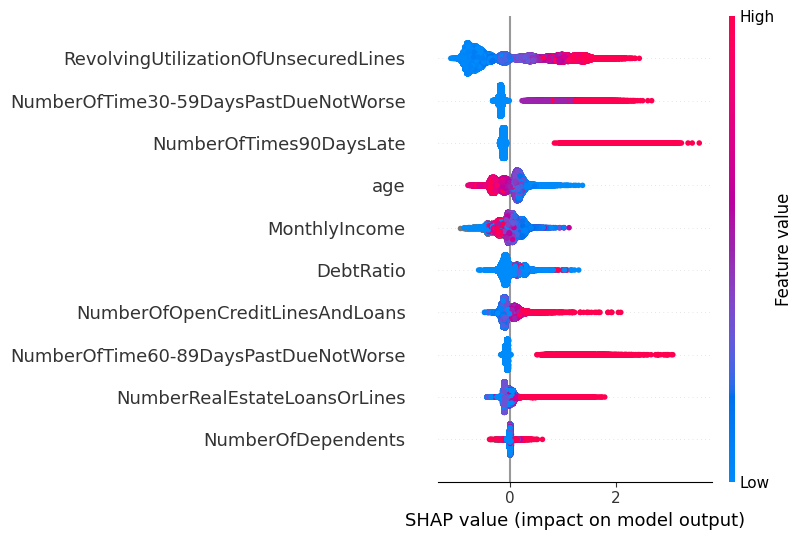

best_feature_model Results


,Dataset,Treshold,Balanced Accuracy,Precision,Recall,F1,AUC,KS,Brier
0,Train,0.211055,0.720537,0.431517,0.487035,0.457598,0.881342,0.604027,0.047282
1,Valid,0.221106,0.705647,0.424477,0.455528,0.439455,0.858196,0.569636,0.049341
2,Test,0.175879,0.721122,0.354013,0.508728,0.417498,0.850497,0.539348,0.050343


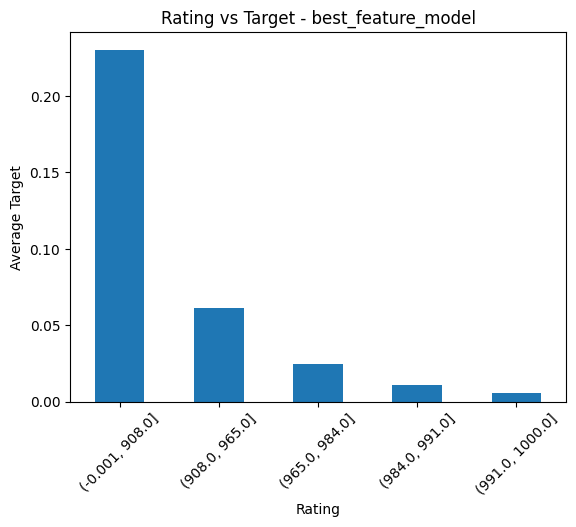

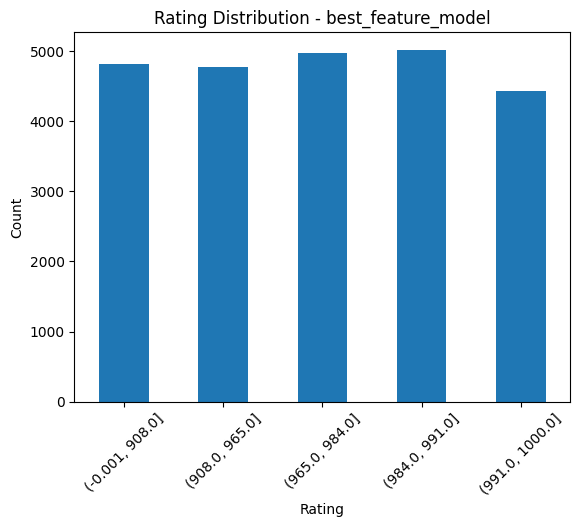

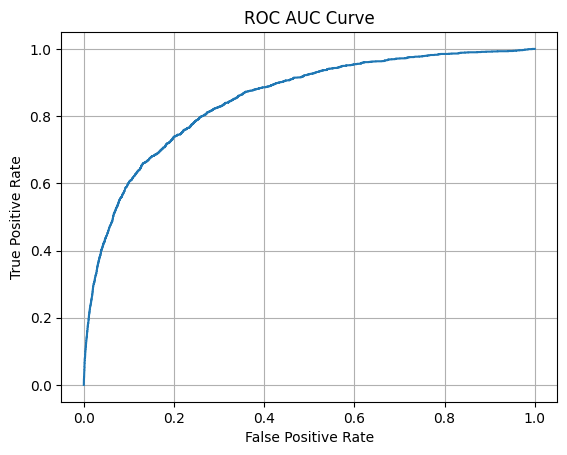

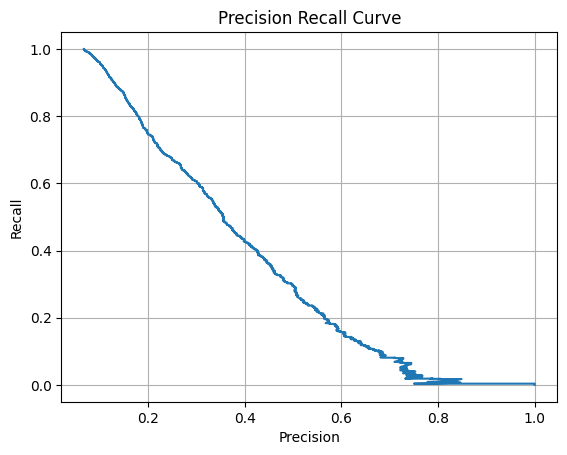

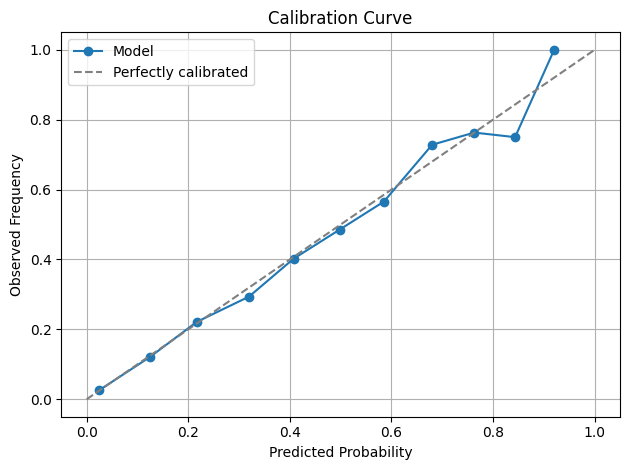

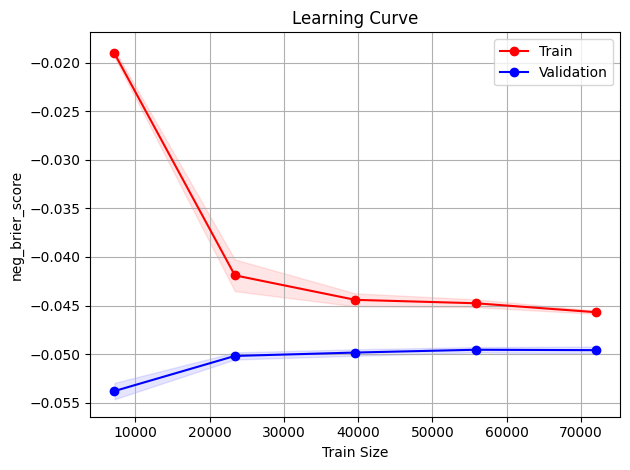

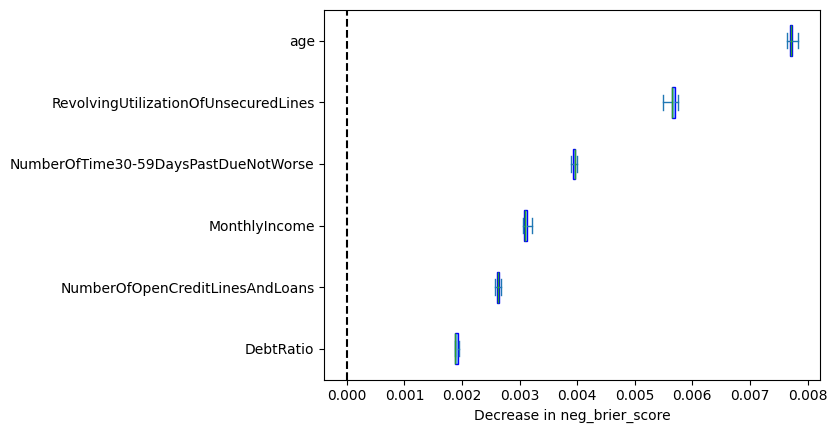

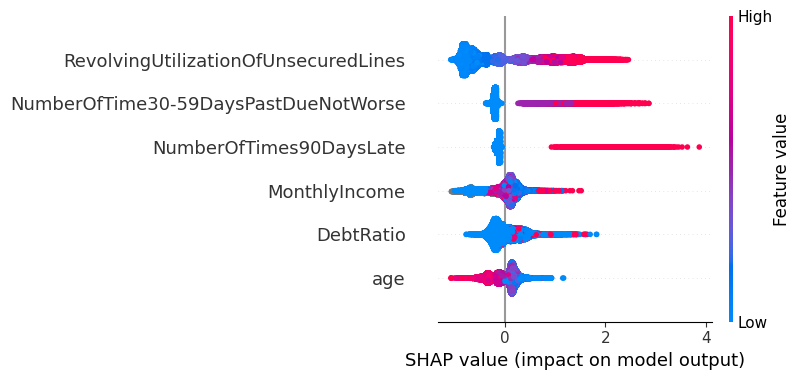

best_params_model Results


,Dataset,Treshold,Balanced Accuracy,Precision,Recall,F1,AUC,KS,Brier
0,Train,0.190955,0.718822,0.395215,0.491523,0.438139,0.864455,0.571230,0.048972
1,Valid,0.211055,0.711953,0.423697,0.469659,0.445496,0.860320,0.567247,0.049157
2,Test,0.190955,0.713431,0.380648,0.483167,0.425824,0.851575,0.542881,0.050077


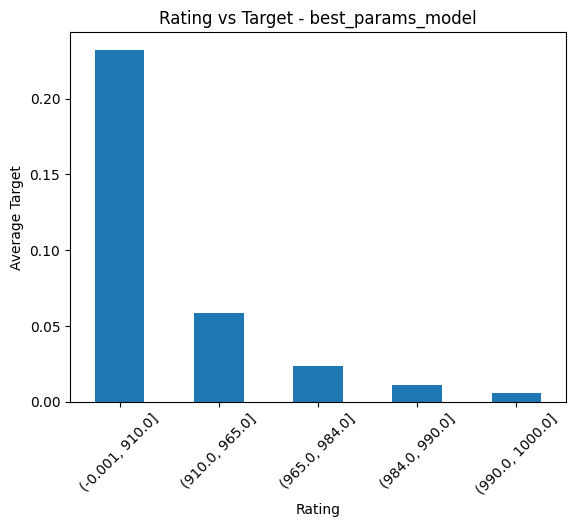

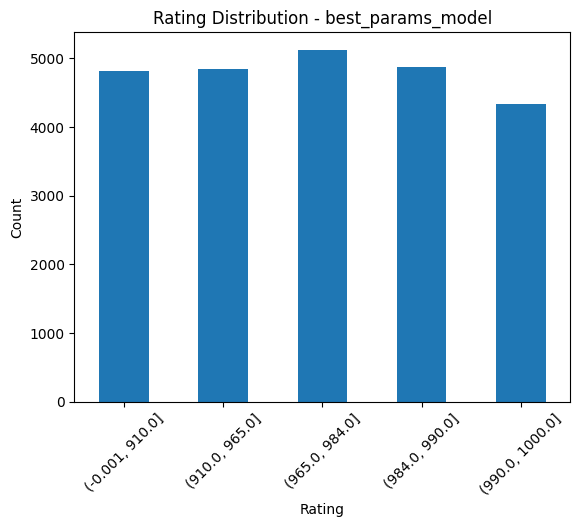

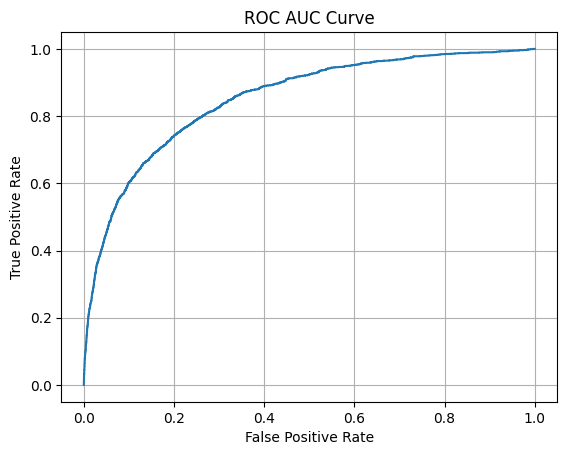

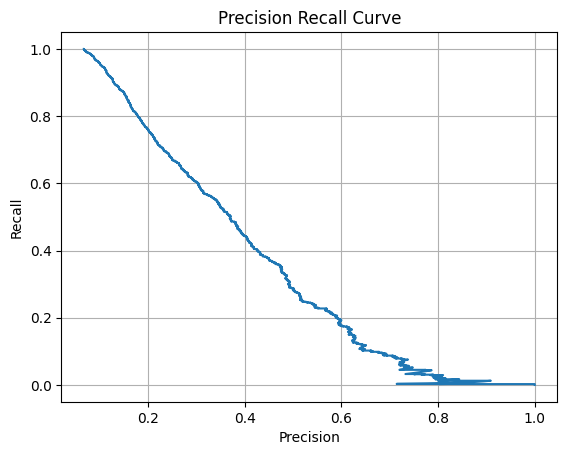

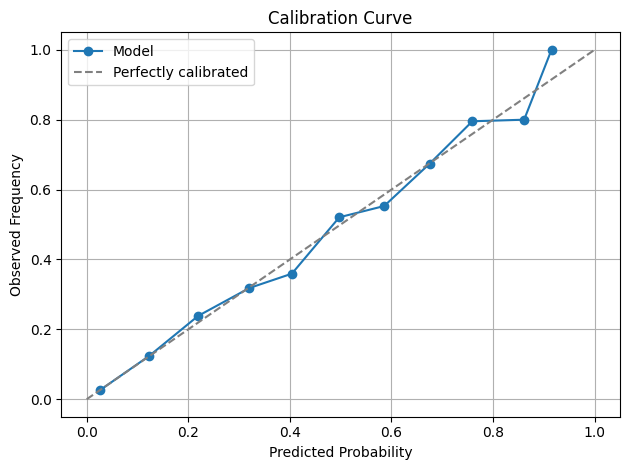

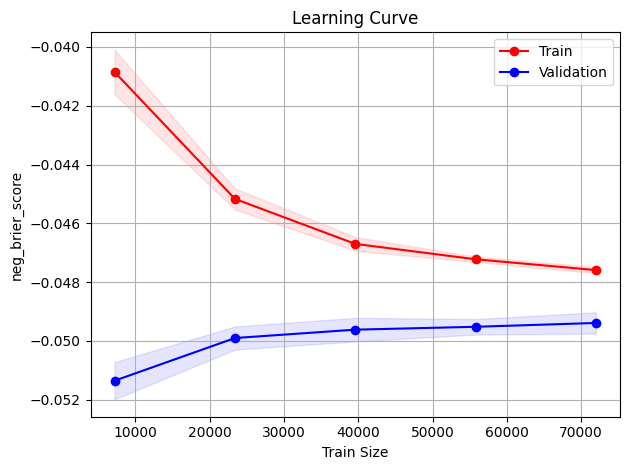

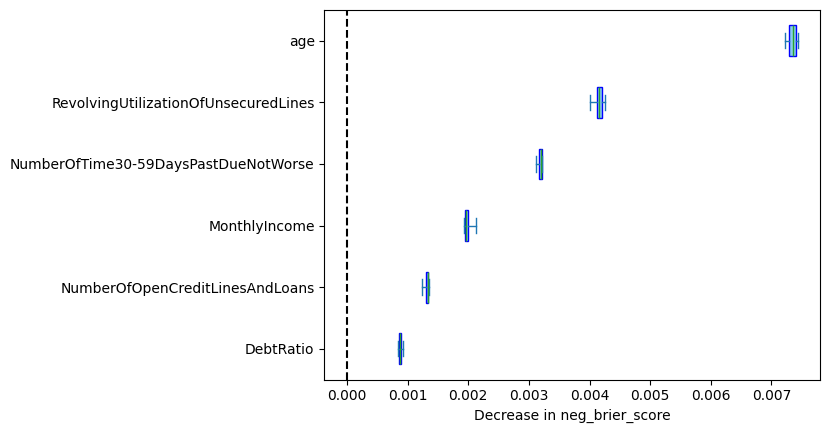

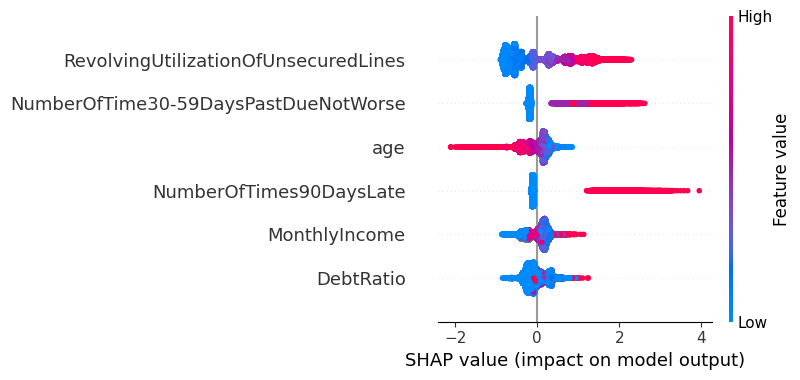

In [8]:
a.get_result_analysis()

In [10]:
acv = AutoMLHistGradientBoostingClassifierCV(
    X_train, y_train, 
    X_test, y_test, 
    target='target', 
    best_features=best_features_class,
    n_trials=50,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc'
)

In [11]:
acv.train()

In [12]:
acv.get_metrics()

,Dataset,Treshold,Balanced Accuracy,Precision,Recall,F1,AUC,KS,Brier,Model
0,Train CV,0.500000,0.582406,0.582198,0.173873,0.266999,0.862678,0.575505,0.049598,Base Model
1,Test,0.266332,0.699536,0.437616,0.439526,0.438569,0.859912,0.563715,0.049492,Base Model
2,Train CV,0.500000,0.570083,0.594273,0.147441,0.236033,0.850998,0.554814,0.050466,Best Feature Model
3,Test,0.175879,0.721122,0.354013,0.508728,0.417498,0.850497,0.539348,0.050343,Best Feature Model
4,Train CV,0.500000,0.578494,0.604553,0.164728,0.258784,0.853031,0.554954,0.050241,Best Params Model
5,Test,0.185930,0.717636,0.376784,0.493766,0.427415,0.851696,0.545891,0.050044,Best Params Model


base_model Results


,Dataset,Treshold,Balanced Accuracy,Precision,Recall,F1,AUC,KS,Brier
0,Train CV,0.500000,0.582406,0.582198,0.173873,0.266999,0.862678,0.575505,0.049598
1,Test,0.266332,0.699536,0.437616,0.439526,0.438569,0.859912,0.563715,0.049492


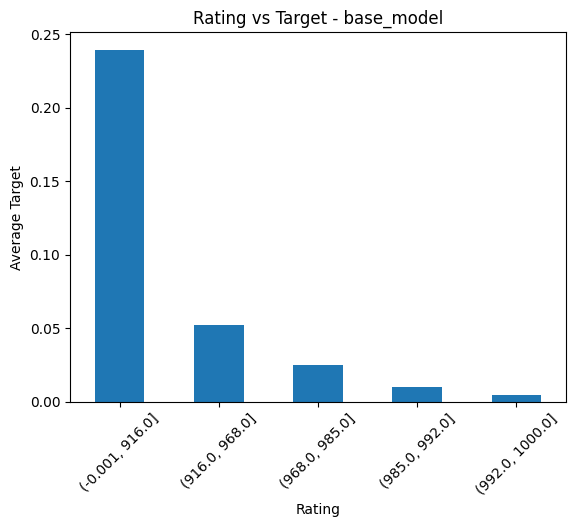

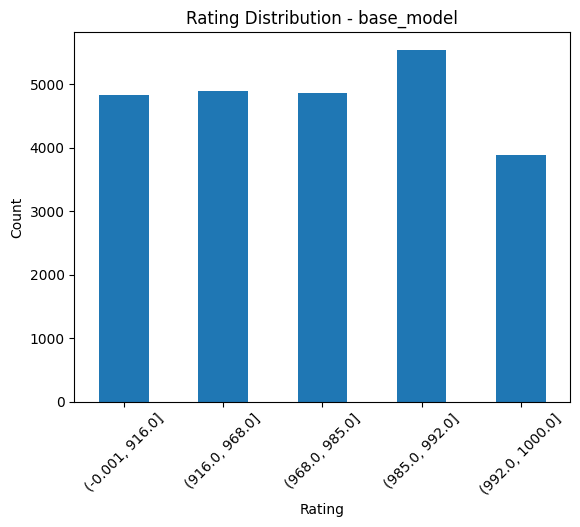

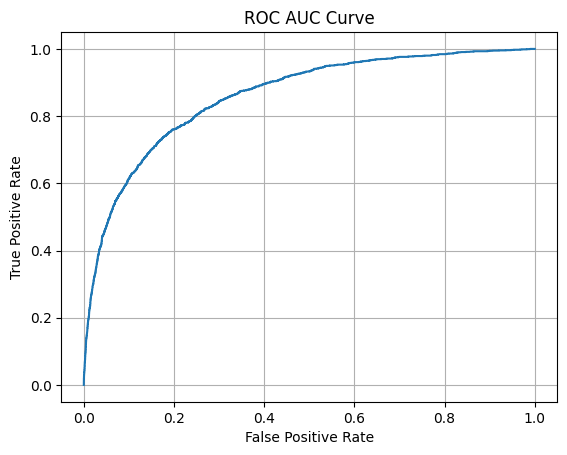

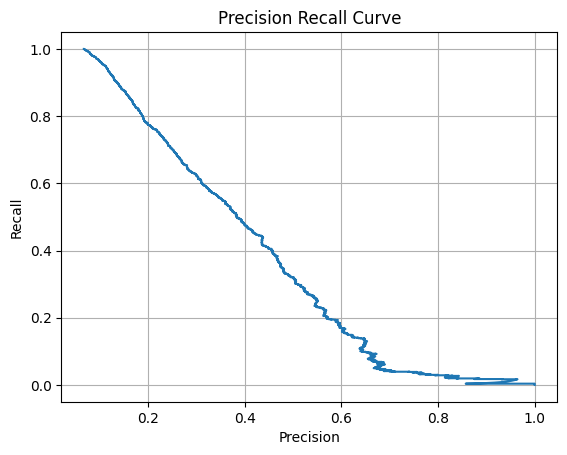

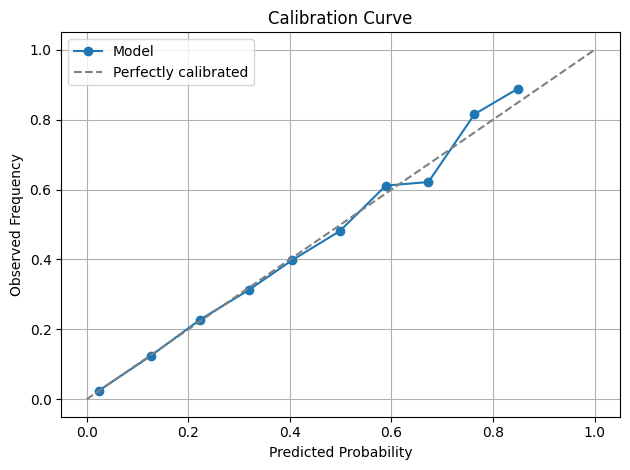

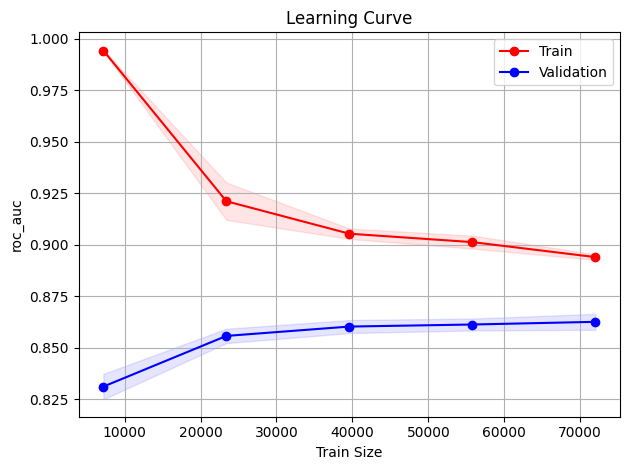

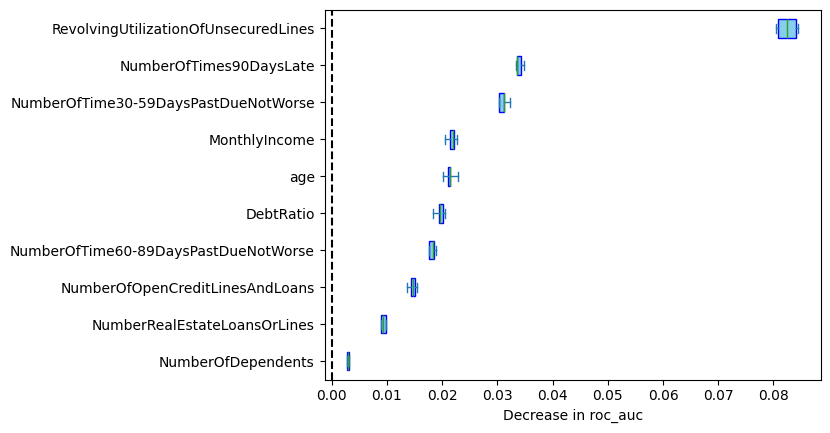

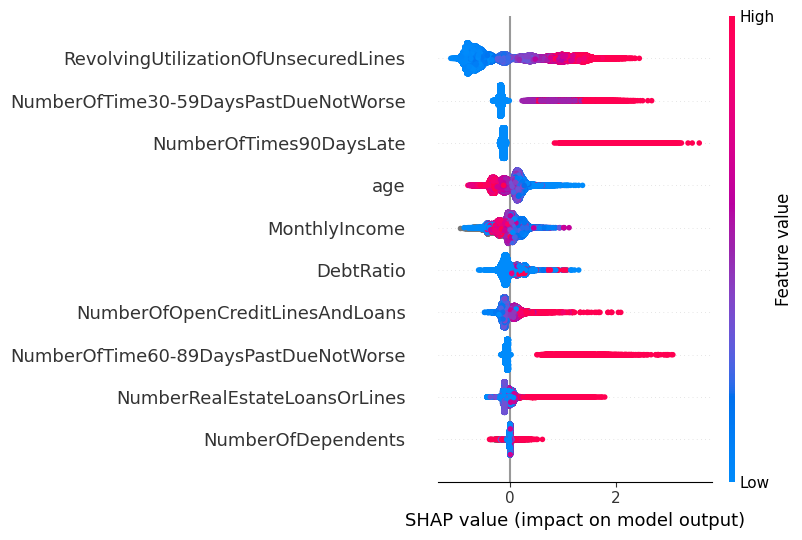

best_feature_model Results


,Dataset,Treshold,Balanced Accuracy,Precision,Recall,F1,AUC,KS,Brier
0,Train CV,0.500000,0.570083,0.594273,0.147441,0.236033,0.850998,0.554814,0.050466
1,Test,0.175879,0.721122,0.354013,0.508728,0.417498,0.850497,0.539348,0.050343


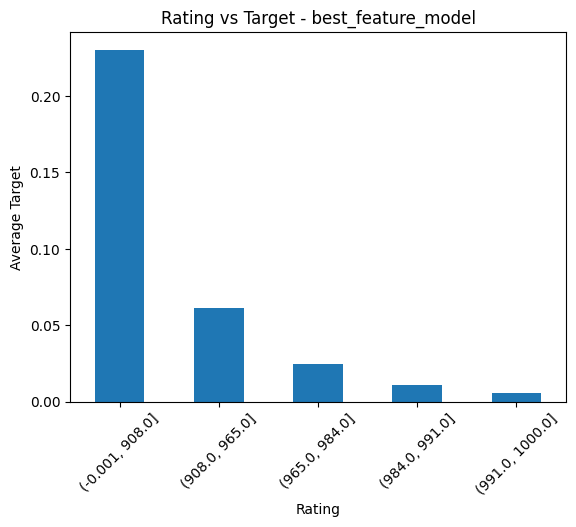

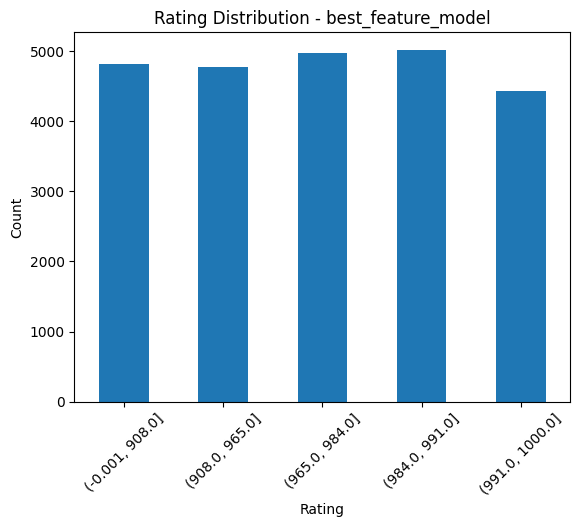

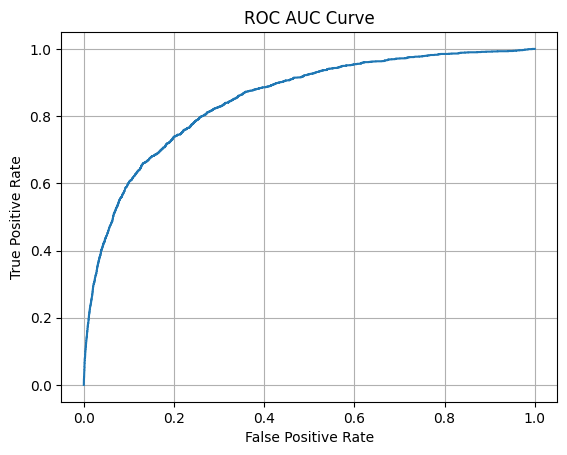

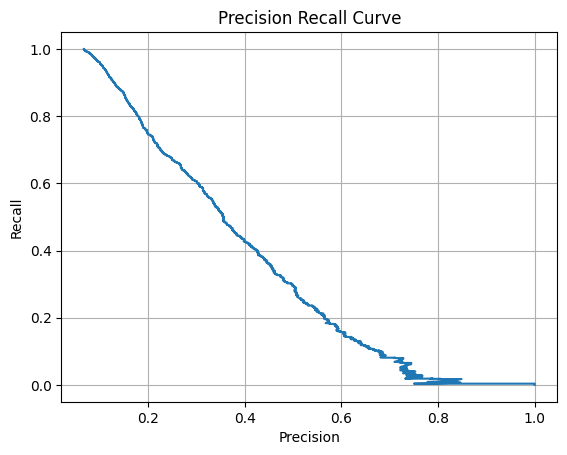

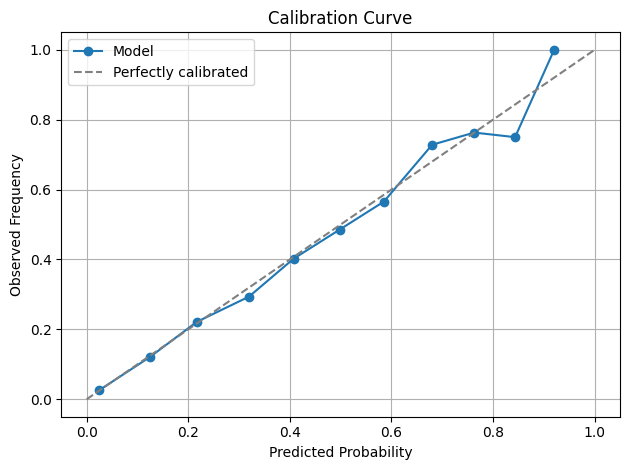

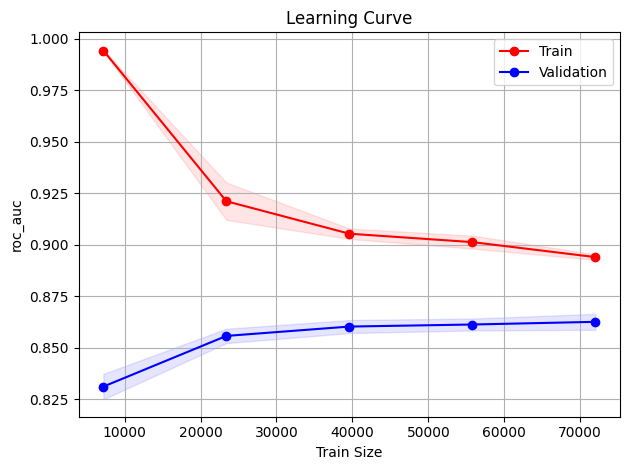

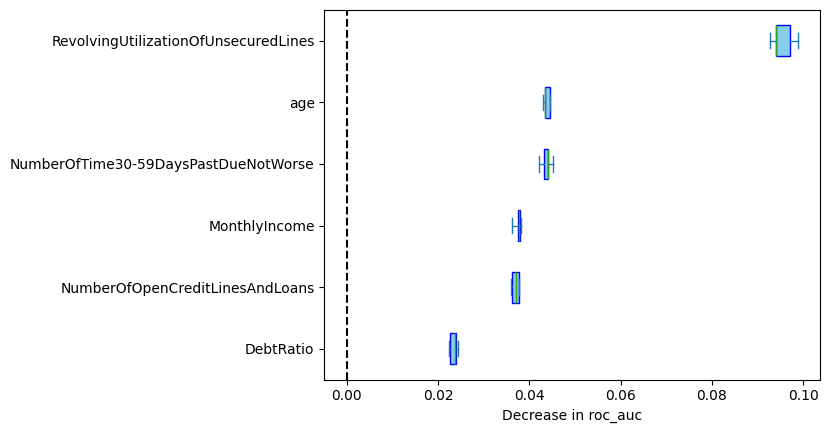

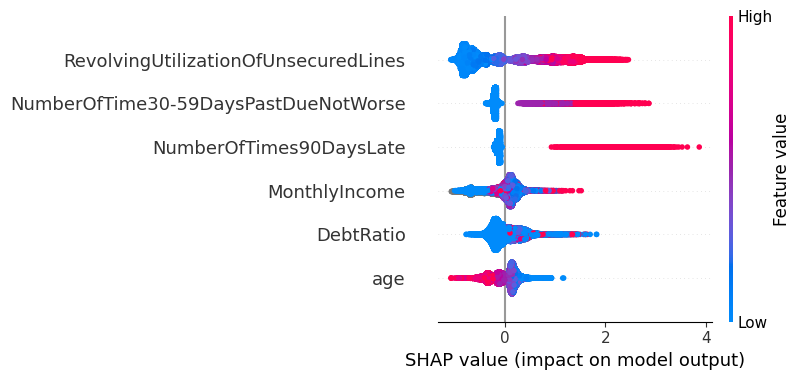

best_params_model Results


,Dataset,Treshold,Balanced Accuracy,Precision,Recall,F1,AUC,KS,Brier
0,Train CV,0.50000,0.578494,0.604553,0.164728,0.258784,0.853031,0.554954,0.050241
1,Test,0.18593,0.717636,0.376784,0.493766,0.427415,0.851696,0.545891,0.050044


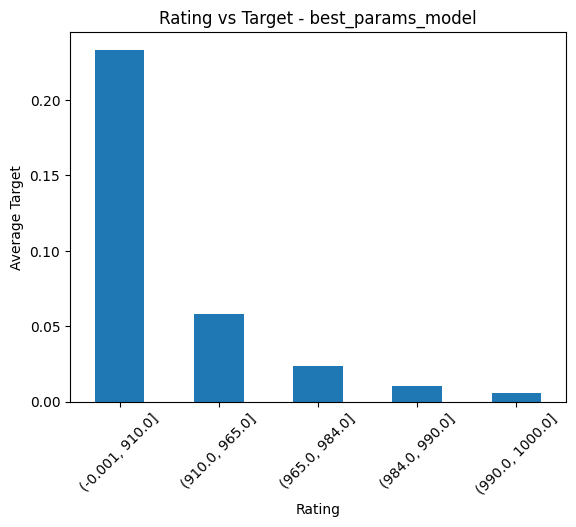

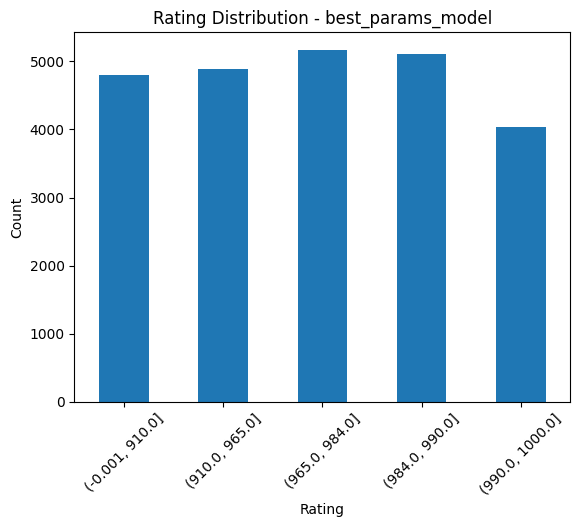

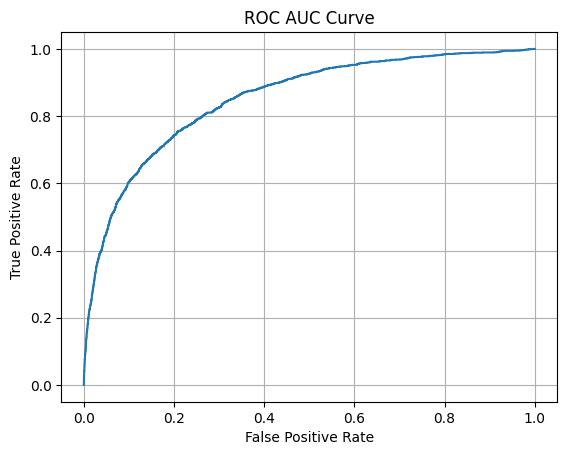

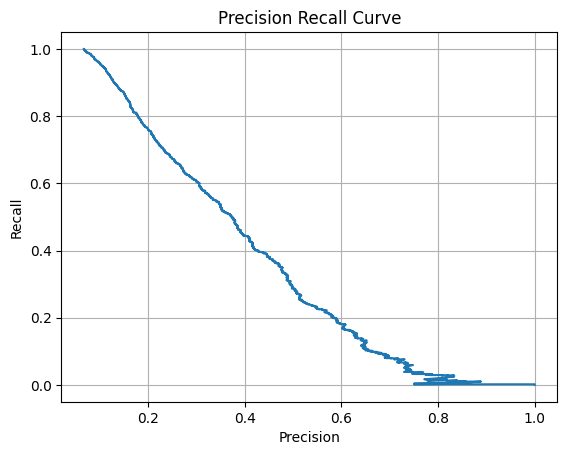

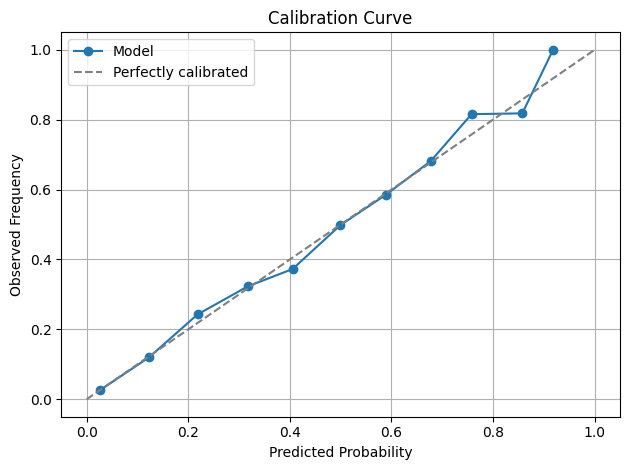

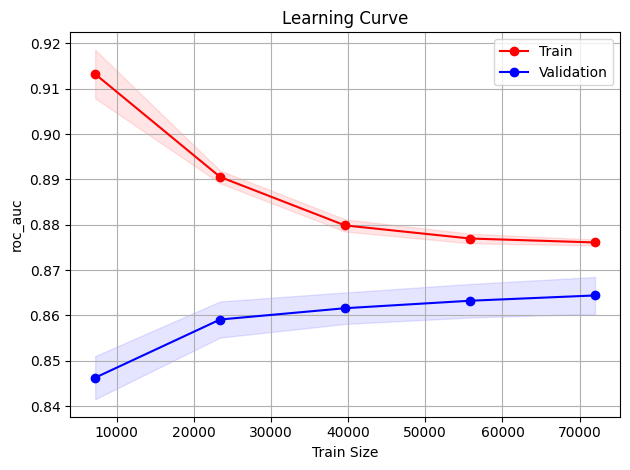

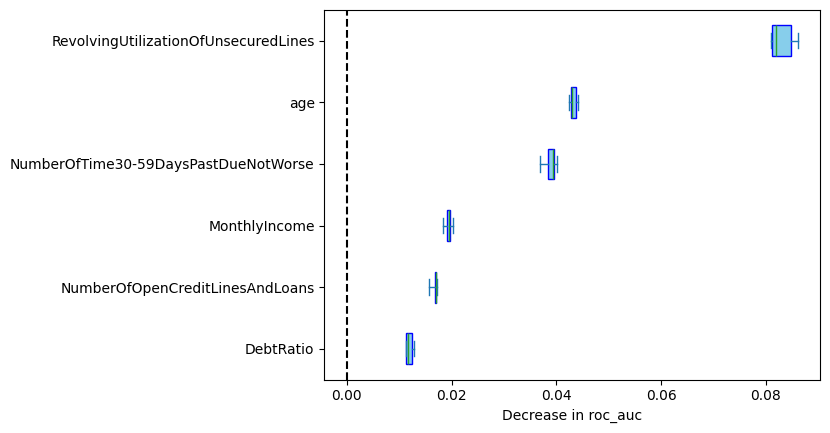

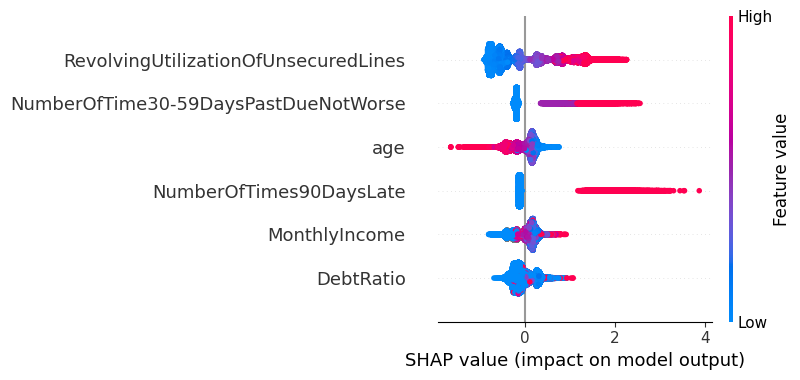

In [13]:
acv.get_result_analysis()